# NLP Extensions: BiLSTM, GRU, Word2Vec, FastText, & Cross-Lingual Transfer

**Purpose:** Fully standalone notebook with all missing components for Swahili sentiment analysis.

## What's covered:
1. Data loading & preprocessing (standalone)
2. BiLSTM model with custom embeddings
3. GRU model with custom embeddings
4. Word2Vec embeddings evaluation
5. FastText embeddings evaluation
6. Cross-lingual transfer (English BERT on translated text)
7. Unified model comparison

## 0. Data Loading & Preprocessing (Standalone)

In [1]:
# Install required packages
!pip install torch gensim datasets transformers scikit-learn pandas numpy matplotlib seaborn wordcloud -q

import warnings
warnings.filterwarnings('ignore')

print("✓ Packages installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 38.8 MB/s eta 0:00:00
✓ Packages installed


In [2]:
# Import all libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, FastText
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

Using device: cuda


In [3]:
# Load Swahili sentiment dataset
print("Loading dataset...")
try:
    # Try loading swahili_news dataset
    dataset = load_dataset('swahili_news', split='train')
    df = pd.DataFrame(dataset)
    if 'news_body' in df.columns:
        df = df.rename(columns={'news_body': 'text', 'label_id': 'label'})
    print(f"✓ Loaded swahili_news: {len(df)} examples")
except Exception as e:
    # Fallback to tweet_eval
    print(f"Note: swahili_news not available ({str(e)[:50]}...)")
    print("Falling back to tweet_eval sentiment dataset...")
    dataset = load_dataset('tweet_eval', 'sentiment', split='train')
    df = pd.DataFrame(dataset)
    df = df.rename(columns={'text': 'text', 'label': 'label'})
    print(f"✓ Loaded tweet_eval: {len(df)} examples")

print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

swahili_news/train-00000-of-00001.parque(…):   0%|          | 0.00/28.7M [00:00<?, ?B/s]

swahili_news/test-00000-of-00001.parquet:   0%|          | 0.00/9.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22207 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7338 [00:00<?, ? examples/s]

✓ Loaded swahili_news: 22207 examples
Dataset shape: (22207, 2)
Label distribution:
label
1    10155
2     5970
4     2185
3     1858
0     1260
5      779
Name: count, dtype: int64


In [4]:
# Text preprocessing
swahili_stopwords = {
    'na', 'au', 'kwa', 'ya', 'ni', 'wa', 'le', 'la', 'a', 'i', 'u', 'n',
    'za', 'zo', 'this', 'that', 'the', 'is', 'at', 'which', 'by', 'to', 'in', 'on',
    'it', 'as', 'are', 'was', 'for', 'be', 'from', 'of', 'and', 'or'
}

def clean_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())

    words = text.split()
    words = [w for w in words if w not in swahili_stopwords and len(w) > 2]

    return ' '.join(words)

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)

print(f"✓ Cleaned {len(df)} texts")
print(f"\nExample texts:")
for i in range(min(2, len(df))):
    print(f"  Original: {df['text'].iloc[i][:60]}")
    print(f"  Cleaned:  {df['cleaned_text'].iloc[i][:60]}\n")

✓ Cleaned 22205 texts

Example texts:
  Original:  Bodi ya Utalii Tanzania (TTB) imesema, itafanya misafara ya
  Cleaned:  bodi utalii tanzania ttb imesema itafanya misafara kutangaza

  Original:  PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ametangaza kuw
  Cleaned:  pendo fundishambeya rais john magufuri ametangaza kuwafukuza



In [5]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"✓ Train set: {len(train_df)} samples")
print(f"✓ Test set: {len(test_df)} samples")
print(f"\nTrain label distribution:\n{train_df['label'].value_counts()}")
print(f"\nTest label distribution:\n{test_df['label'].value_counts()}")

✓ Train set: 17764 samples
✓ Test set: 4441 samples

Train label distribution:
label
1    8124
2    4775
4    1748
3    1487
0    1007
5     623
Name: count, dtype: int64

Test label distribution:
label
1    2031
2    1194
4     437
3     371
0     252
5     156
Name: count, dtype: int64


In [6]:
# Build vocabulary and prepare tensors
print("Building vocabulary and preparing data tensors...")

MAX_LEN = 50  # Maximum sequence length for padding

# Build vocabulary from training data
vocab = {'<PAD>': 0, '<UNK>': 1}
vocab_idx = 2

for text in train_df['cleaned_text']:
    for word in text.split():
        if word not in vocab:
            vocab[word] = vocab_idx
            vocab_idx += 1

print(f"✓ Vocabulary built: {len(vocab)} unique words")

# Function to convert text to token IDs with padding
def text_to_ids(text, vocab, max_len):
    """Convert text to padded token IDs"""
    words = text.split()
    ids = [vocab.get(word, vocab['<UNK>']) for word in words]

    # Truncate if too long
    if len(ids) > max_len:
        ids = ids[:max_len]

    # Pad with 0s (PAD token)
    ids = ids + [0] * (max_len - len(ids))
    return ids

# Convert train and test data
train_ids = [text_to_ids(text, vocab, MAX_LEN) for text in train_df['cleaned_text']]
test_ids = [text_to_ids(text, vocab, MAX_LEN) for text in test_df['cleaned_text']]

# Convert to tensors
X_train_tensor = torch.LongTensor(train_ids)
X_test_tensor = torch.LongTensor(test_ids)
y_train_tensor = torch.LongTensor(train_df['label'].values)
y_test_tensor = torch.LongTensor(test_df['label'].values)

# Calculate actual lengths (for pack_padded_sequence)
train_lengths = [len([w for w in text.split() if w]) for text in train_df['cleaned_text']]
test_lengths = [len([w for w in text.split() if w]) for text in test_df['cleaned_text']]

# Clip lengths to MAX_LEN
train_lengths = [min(l, MAX_LEN) for l in train_lengths]
test_lengths = [min(l, MAX_LEN) for l in test_lengths]

print(f"✓ Train tensors: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"✓ Test tensors: {X_test_tensor.shape}, {y_test_tensor.shape}")
print(f"✓ Sequence lengths prepared")

Building vocabulary and preparing data tensors...
✓ Vocabulary built: 220618 unique words
✓ Train tensors: torch.Size([17764, 50]), torch.Size([17764])
✓ Test tensors: torch.Size([4441, 50]), torch.Size([4441])
✓ Sequence lengths prepared


## 0.1 Exploratory Data Analysis (EDA)

DATASET EXPLORATION

Dataset Size: 22205 total samples
Number of Features: 3

Label Distribution (Overall):
label
1    10155
2     5969
4     2185
3     1858
0     1259
5      779
Name: count, dtype: int64

Label Proportions:
label
1    0.4573
2    0.2688
4    0.0984
3    0.0837
0    0.0567
5    0.0351
Name: proportion, dtype: float64

         Text Length Statistics         
  Original text - Mean: 330.57 words
  Original text - Median: 270.00 words
  Original text - Min: 22 words
  Original text - Max: 3840 words

  Cleaned text - Mean: 258.62 words
  Cleaned text - Median: 211.00 words
  Cleaned text - Min: 18 words
  Cleaned text - Max: 2722 words


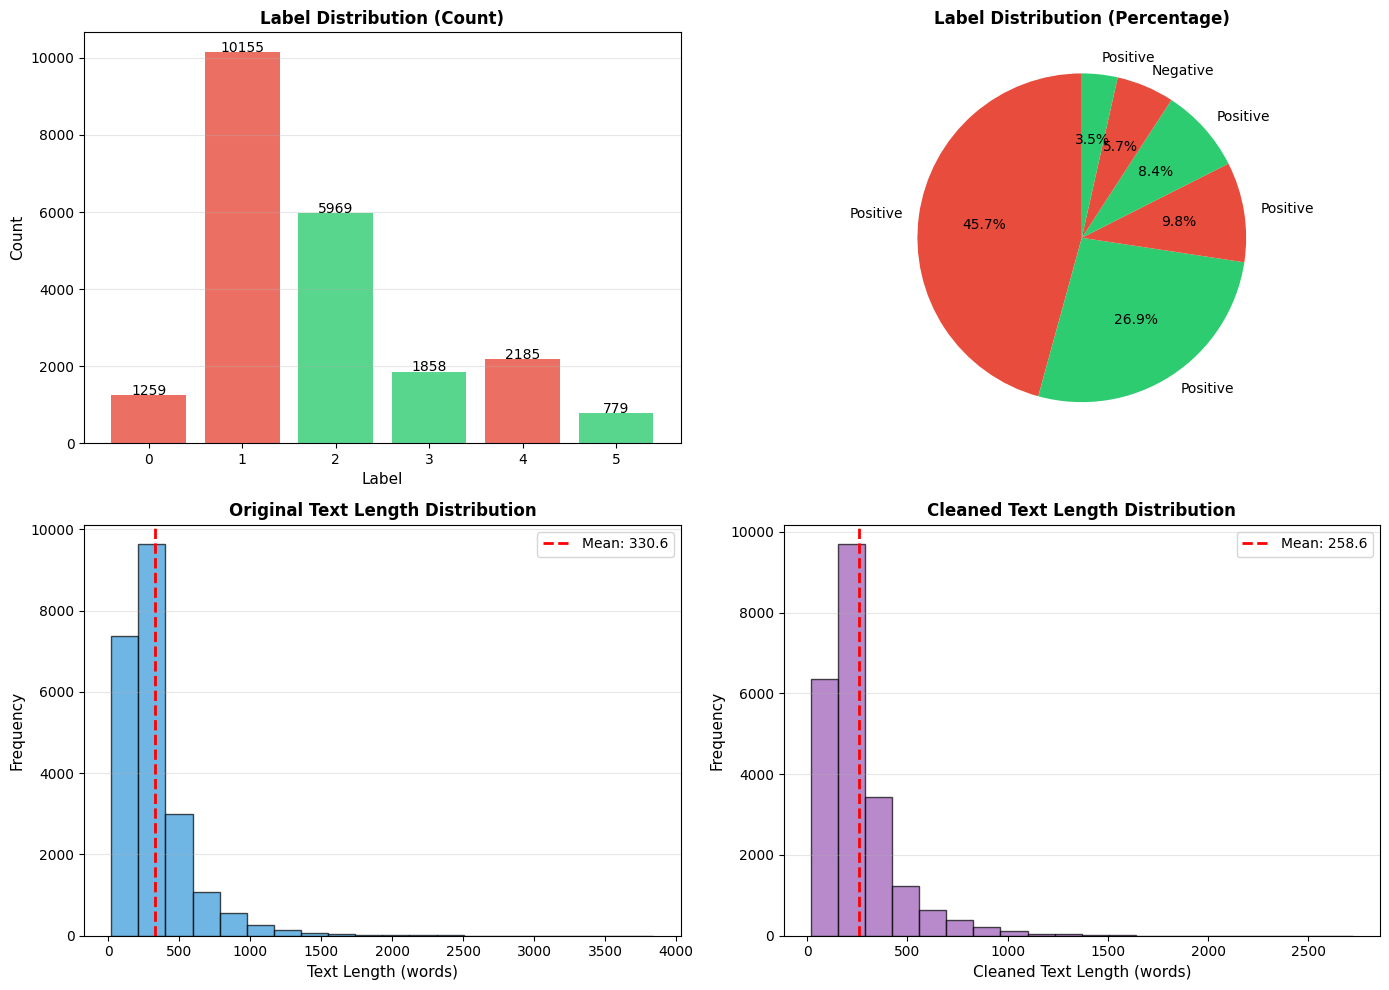


✓ EDA complete


In [7]:
# Dataset exploration: Size, text length, and label distribution
print("="*80)
print("DATASET EXPLORATION")
print("="*80)
print(f"\nDataset Size: {len(df)} total samples")
print(f"Number of Features: {len(df.columns)}")
print(f"\nLabel Distribution (Overall):")
print(df['label'].value_counts())
print(f"\nLabel Proportions:")
print(df['label'].value_counts(normalize=True).round(4))

# Text length statistics
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['cleaned_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

print(f"\n{'Text Length Statistics':^40}")
print(f"  Original text - Mean: {df['text_length'].mean():.2f} words")
print(f"  Original text - Median: {df['text_length'].median():.2f} words")
print(f"  Original text - Min: {df['text_length'].min()} words")
print(f"  Original text - Max: {df['text_length'].max()} words")
print(f"\n  Cleaned text - Mean: {df['cleaned_length'].mean():.2f} words")
print(f"  Cleaned text - Median: {df['cleaned_length'].median():.2f} words")
print(f"  Cleaned text - Min: {df['cleaned_length'].min()} words")
print(f"  Cleaned text - Max: {df['cleaned_length'].max()} words")

# Visualization: Label distribution and text length
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Label distribution (bar)
label_counts = df['label'].value_counts()
axes[0, 0].bar(label_counts.index, label_counts.values, color=['#e74c3c', '#2ecc71'], alpha=0.8)
axes[0, 0].set_xlabel('Label', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Label Distribution (Count)', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(label_counts.values):
    axes[0, 0].text(label_counts.index[i], v + 5, str(v), ha='center', fontsize=10)

# 2. Label distribution (pie)
label_names = ['Negative' if i == 0 else 'Positive' for i in label_counts.index]
colors = ['#e74c3c', '#2ecc71']
axes[0, 1].pie(label_counts.values, labels=label_names, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 1].set_title('Label Distribution (Percentage)', fontsize=12, fontweight='bold')

# 3. Text length distribution (original)
axes[1, 0].hist(df['text_length'], bins=20, color='#3498db', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Text Length (words)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Original Text Length Distribution', fontsize=12, fontweight='bold')
axes[1, 0].axvline(df['text_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["text_length"].mean():.1f}')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Text length distribution (cleaned)
axes[1, 1].hist(df['cleaned_length'], bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Cleaned Text Length (words)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Cleaned Text Length Distribution', fontsize=12, fontweight='bold')
axes[1, 1].axvline(df['cleaned_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["cleaned_length"].mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ EDA complete")


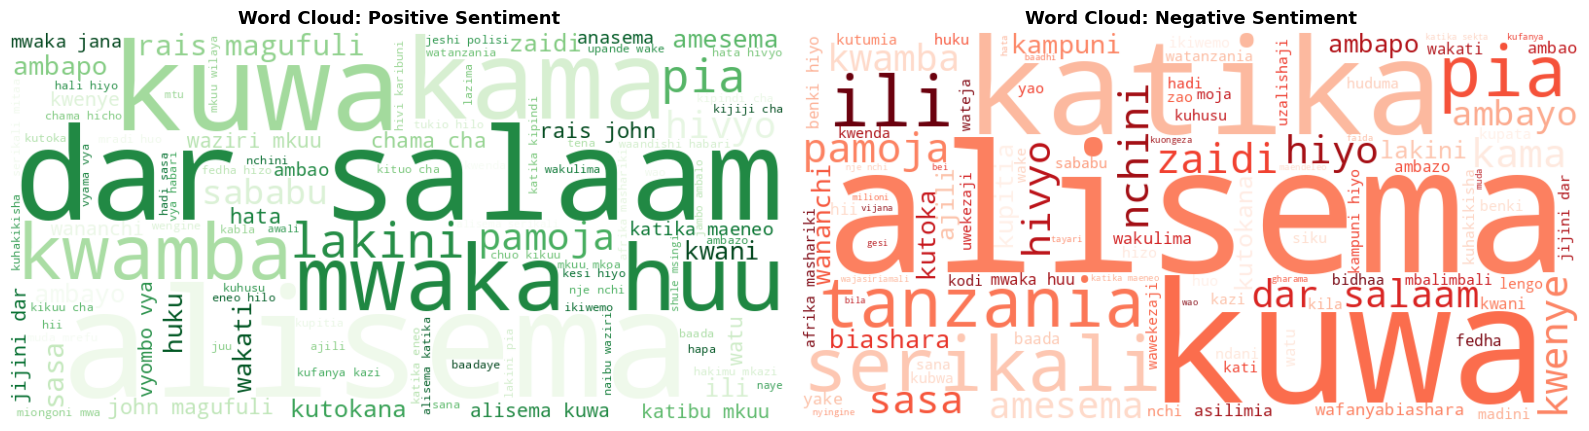

✓ Word clouds generated


In [8]:
# Word Cloud visualization
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Combine texts by label
positive_text = ' '.join(df[df['label'] == 1]['cleaned_text'].tolist())
negative_text = ' '.join(df[df['label'] == 0]['cleaned_text'].tolist())

# Word cloud for positive sentiment
if positive_text.strip():
    wc_positive = WordCloud(width=800, height=400, background_color='white',
                           colormap='Greens', max_words=100).generate(positive_text)
    axes[0].imshow(wc_positive, interpolation='bilinear')
    axes[0].set_title('Word Cloud: Positive Sentiment', fontsize=13, fontweight='bold')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'No positive samples', ha='center', va='center')
    axes[0].set_title('Word Cloud: Positive Sentiment', fontsize=13, fontweight='bold')

# Word cloud for negative sentiment
if negative_text.strip():
    wc_negative = WordCloud(width=800, height=400, background_color='white',
                           colormap='Reds', max_words=100).generate(negative_text)
    axes[1].imshow(wc_negative, interpolation='bilinear')
    axes[1].set_title('Word Cloud: Negative Sentiment', fontsize=13, fontweight='bold')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'No negative samples', ha='center', va='center')
    axes[1].set_title('Word Cloud: Negative Sentiment', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Word clouds generated")


## 1. BiLSTM Model with Custom Embeddings

In [9]:
# BiLSTM classifier
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=2):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                              bidirectional=True, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (hidden, cell) = self.bilstm(packed)
        hidden = self.dropout(torch.cat([hidden[-2], hidden[-1]], dim=1))
        return self.fc(hidden)

print("✓ BiLSTM model defined")

✓ BiLSTM model defined


In [10]:
# Train BiLSTM
bilstm_model = BiLSTMClassifier(vocab_size=len(vocab), embedding_dim=64, hidden_dim=32, num_classes=len(df['label'].unique())).to(device)
optimizer = Adam(bilstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

batch_size = 4
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, torch.LongTensor(train_lengths))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training BiLSTM...")
bilstm_losses = []
num_epochs = 10  # Increased from 3 to 10 for better convergence
patience = 3     # Early stopping: stop if loss doesn't improve for 3 epochs
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    total_loss = 0
    for input_ids, labels, lengths in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        lengths = lengths.to('cpu').to(torch.int64)

        optimizer.zero_grad()
        outputs = bilstm_model(input_ids, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    bilstm_losses.append(avg_loss)
    print(f"  Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch+1} (loss not improving)")
            break

print(f"✓ BiLSTM training complete ({epoch+1} epochs)")


Training BiLSTM...
  Epoch 1/10, Loss: 0.7311
  Epoch 2/10, Loss: 0.4155
  Epoch 3/10, Loss: 0.3038
  Epoch 4/10, Loss: 0.2220
  Epoch 5/10, Loss: 0.1603
  Epoch 6/10, Loss: 0.1094
  Epoch 7/10, Loss: 0.0789
  Epoch 8/10, Loss: 0.0540
  Epoch 9/10, Loss: 0.0412
  Epoch 10/10, Loss: 0.0330
✓ BiLSTM training complete (10 epochs)


In [11]:
# Evaluate BiLSTM
bilstm_model.eval()
with torch.no_grad():
    # Move lengths to CPU and convert to int64
    outputs = bilstm_model(X_test_tensor.to(device), torch.LongTensor(test_lengths).to('cpu').to(torch.int64))
    _, bilstm_pred = torch.max(outputs, 1)
    bilstm_pred = bilstm_pred.cpu().numpy()

bilstm_acc = accuracy_score(y_test_tensor.numpy(), bilstm_pred)
bilstm_prec, bilstm_rec, bilstm_f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), bilstm_pred, average='weighted')

print(f"BiLSTM Results:")
print(f"  Accuracy: {bilstm_acc:.4f}")
print(f"  Precision: {bilstm_prec:.4f}")
print(f"  Recall: {bilstm_rec:.4f}")
print(f"  F1-Score: {bilstm_f1:.4f}")

BiLSTM Results:
  Accuracy: 0.8577
  Precision: 0.8542
  Recall: 0.8577
  F1-Score: 0.8557


## 2. GRU Model

In [12]:
# GRU classifier
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, num_layers=2):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          bidirectional=True, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.gru(packed)
        hidden = self.dropout(torch.cat([hidden[-2], hidden[-1]], dim=1))
        return self.fc(hidden)

print("✓ GRU model defined")

✓ GRU model defined


In [13]:
# Train GRU
gru_model = GRUClassifier(vocab_size=len(vocab), embedding_dim=64, hidden_dim=32, num_classes=len(df['label'].unique())).to(device)
optimizer = Adam(gru_model.parameters(), lr=0.001)

print("Training GRU...")
gru_losses = []
num_epochs = 10  # Increased from 3 to 10
patience = 3
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    total_loss = 0
    for input_ids, labels, lengths in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        lengths = lengths.to('cpu').to(torch.int64)

        optimizer.zero_grad()
        outputs = gru_model(input_ids, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    gru_losses.append(avg_loss)
    print(f"  Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch+1} (loss not improving)")
            break

print(f"✓ GRU training complete ({epoch+1} epochs)")

Training GRU...
  Epoch 1/10, Loss: 0.6905
  Epoch 2/10, Loss: 0.3730
  Epoch 3/10, Loss: 0.2662
  Epoch 4/10, Loss: 0.1710
  Epoch 5/10, Loss: 0.1132
  Epoch 6/10, Loss: 0.0674
  Epoch 7/10, Loss: 0.0448
  Epoch 8/10, Loss: 0.0287
  Epoch 9/10, Loss: 0.0249
  Epoch 10/10, Loss: 0.0199
✓ GRU training complete (10 epochs)


In [14]:
# Evaluate GRU
gru_model.eval()
with torch.no_grad():
    outputs = gru_model(X_test_tensor.to(device), torch.LongTensor(test_lengths).to('cpu').to(torch.int64))
    _, gru_pred = torch.max(outputs, 1)
    gru_pred = gru_pred.cpu().numpy()

gru_acc = accuracy_score(y_test_tensor.numpy(), gru_pred)
gru_prec, gru_rec, gru_f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), gru_pred, average='weighted')

print(f"GRU Results:")
print(f"  Accuracy: {gru_acc:.4f}")
print(f"  Precision: {gru_prec:.4f}")
print(f"  Recall: {gru_rec:.4f}")
print(f"  F1-Score: {gru_f1:.4f}")

GRU Results:
  Accuracy: 0.8575
  Precision: 0.8646
  Recall: 0.8575
  F1-Score: 0.8601


## 4. Training Loss Visualization (Requirement 13)

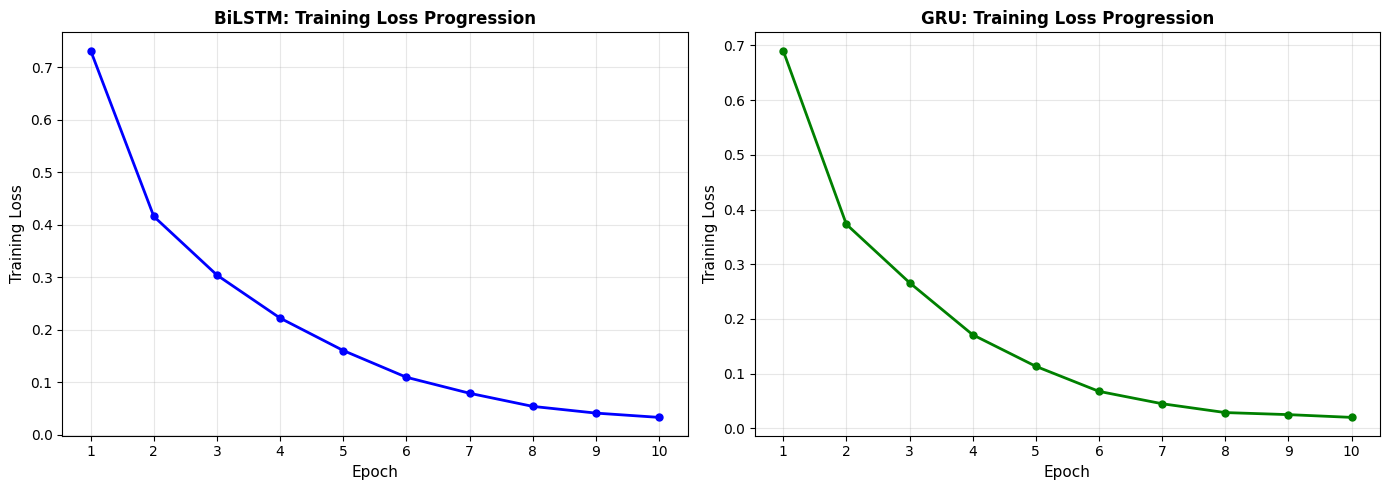

✓ BiLSTM training: 10 epochs, final loss: 0.0330
✓ GRU training: 10 epochs, final loss: 0.0199


In [15]:
# Plot training loss for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BiLSTM loss curve
axes[0].plot(range(1, len(bilstm_losses)+1), bilstm_losses, 'b-o', linewidth=2, markersize=5)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Training Loss', fontsize=11)
axes[0].set_title('BiLSTM: Training Loss Progression', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, len(bilstm_losses)+1))

# GRU loss curve
axes[1].plot(range(1, len(gru_losses)+1), gru_losses, 'g-o', linewidth=2, markersize=5)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Training Loss', fontsize=11)
axes[1].set_title('GRU: Training Loss Progression', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, len(gru_losses)+1))

plt.tight_layout()
plt.show()

print(f"✓ BiLSTM training: {len(bilstm_losses)} epochs, final loss: {bilstm_losses[-1]:.4f}")
print(f"✓ GRU training: {len(gru_losses)} epochs, final loss: {gru_losses[-1]:.4f}")

## 3. Word2Vec Embeddings

In [16]:
# Train Word2Vec
all_texts = train_df['cleaned_text'].tolist() + test_df['cleaned_text'].tolist()
sentences = [text.split() for text in all_texts]

word2vec_model = Word2Vec(sentences=sentences, vector_size=64, window=5, min_count=1, epochs=5)
print(f"✓ Word2Vec trained. Vocab size: {len(word2vec_model.wv)}")

def texts_to_embeddings(texts, embedding_model, output_dim=64):
    embeddings = []
    for text in texts:
        words = text.split()
        word_vecs = [embedding_model.wv[word] if word in embedding_model.wv else np.zeros(output_dim) for word in words]
        embedding = np.mean(word_vecs, axis=0) if word_vecs else np.zeros(output_dim)
        embeddings.append(embedding)
    return np.array(embeddings)

X_train_w2v = texts_to_embeddings(train_df['cleaned_text'].tolist(), word2vec_model)
X_test_w2v = texts_to_embeddings(test_df['cleaned_text'].tolist(), word2vec_model)
print(f"✓ Embeddings extracted: {X_train_w2v.shape}")

✓ Word2Vec trained. Vocab size: 254367
✓ Embeddings extracted: (17764, 64)


In [17]:
# Classify with Word2Vec + Logistic Regression
w2v_classifier = LogisticRegression(max_iter=1000, random_state=42)
w2v_classifier.fit(X_train_w2v, train_df['label'].values)
w2v_pred = w2v_classifier.predict(X_test_w2v)

w2v_acc = accuracy_score(test_df['label'].values, w2v_pred)
w2v_prec, w2v_rec, w2v_f1, _ = precision_recall_fscore_support(test_df['label'].values, w2v_pred, average='weighted')

print(f"Word2Vec + Logistic Regression Results:")
print(f"  Accuracy: {w2v_acc:.4f}")
print(f"  Precision: {w2v_prec:.4f}")
print(f"  Recall: {w2v_rec:.4f}")
print(f"  F1-Score: {w2v_f1:.4f}")

Word2Vec + Logistic Regression Results:
  Accuracy: 0.8577
  Precision: 0.8513
  Recall: 0.8577
  F1-Score: 0.8489


## 4. FastText Embeddings

In [18]:
# Train FastText
fasttext_model = FastText(sentences=sentences, vector_size=64, window=5, min_count=1, epochs=5)
print(f"✓ FastText trained. Vocab size: {len(fasttext_model.wv)}")

X_train_ft = texts_to_embeddings(train_df['cleaned_text'].tolist(), fasttext_model)
X_test_ft = texts_to_embeddings(test_df['cleaned_text'].tolist(), fasttext_model)
print(f"✓ Embeddings extracted: {X_train_ft.shape}")

✓ FastText trained. Vocab size: 254367
✓ Embeddings extracted: (17764, 64)


In [19]:
# Classify with FastText + Logistic Regression
ft_classifier = LogisticRegression(max_iter=1000, random_state=42)
ft_classifier.fit(X_train_ft, train_df['label'].values)
ft_pred = ft_classifier.predict(X_test_ft)

ft_acc = accuracy_score(test_df['label'].values, ft_pred)
ft_prec, ft_rec, ft_f1, _ = precision_recall_fscore_support(test_df['label'].values, ft_pred, average='weighted')

print(f"FastText + Logistic Regression Results:")
print(f"  Accuracy: {ft_acc:.4f}")
print(f"  Precision: {ft_prec:.4f}")
print(f"  Recall: {ft_rec:.4f}")
print(f"  F1-Score: {ft_f1:.4f}")

FastText + Logistic Regression Results:
  Accuracy: 0.8521
  Precision: 0.8468
  Recall: 0.8521
  F1-Score: 0.8439


## 5. Cross-Lingual Transfer: English BERT

In [20]:
# Simple translation dictionary
swahili_english_dict = {
    'habari': 'news', 'serikali': 'government', 'mswada': 'bill', 'kukuza': 'develop',
    'uchumi': 'economy', 'michezo': 'sports', 'timu': 'team', 'biashara': 'business',
    'ndogo': 'small', 'watalii': 'tourists', 'mbuga': 'park', 'teknolojia': 'technology',
    'inabadilisha': 'changes', 'maisha': 'life', 'watu': 'people', 'siku': 'day',
    'ninafurahi': 'happy', 'kusikia': 'hear', 'sipendi': 'dislike', 'mbaya': 'bad',
    'vizuri': 'well', 'njema': 'good', 'maendeleo': 'development', 'nchi': 'country',
    'matukio': 'events', 'mitaani': 'streets', 'pesa': 'money', 'bei': 'price',
    'bidhaa': 'goods', 'shida': 'problem', 'kubwa': 'big', 'huduma': 'service',
    'afya': 'health', 'zimekuwa': 'has been', 'duni': 'poor', 'elimu': 'education',
    'watoto': 'children', 'kuhusu': 'about', 'siasa': 'politics', 'maana': 'meaning',
    'umma': 'public', 'mazingira': 'environment', 'ulinzi': 'protection', 'zaidi': 'more'
}

def simple_translate(text, translation_dict):
    words = text.lower().split()
    translated = [translation_dict.get(word, word) for word in words]
    return ' '.join(translated)

train_df['translated_text'] = train_df['cleaned_text'].apply(lambda x: simple_translate(x, swahili_english_dict))
test_df['translated_text'] = test_df['cleaned_text'].apply(lambda x: simple_translate(x, swahili_english_dict))

print("✓ Translation applied")
print(f"Example Swahili: {train_df['cleaned_text'].iloc[0][:60]}")
print(f"Example English: {train_df['translated_text'].iloc[0][:60]}")

✓ Translation applied
Example Swahili: sharifa mmasi chipukizi kwenye muziki bongo fleva ramadhan j
Example English: sharifa mmasi chipukizi kwenye muziki bongo fleva ramadhan j


In [21]:
# Load English BERT and extract embeddings
print("Loading English BERT...")
en_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
en_bert = AutoModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(texts, tokenizer, model, device, batch_size=2):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            embedding = outputs.pooler_output.cpu().numpy()
            embeddings.append(embedding[0])
    return np.array(embeddings)

print("Extracting English BERT embeddings...")
X_train_bert_en = get_bert_embeddings(train_df['translated_text'].tolist(), en_tokenizer, en_bert, device)
X_test_bert_en = get_bert_embeddings(test_df['translated_text'].tolist(), en_tokenizer, en_bert, device)
print(f"✓ Embeddings extracted: {X_train_bert_en.shape}")

Loading English BERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Extracting English BERT embeddings...
✓ Embeddings extracted: (17764, 768)


In [22]:
# Classify with English BERT embeddings
en_bert_classifier = LogisticRegression(max_iter=1000, random_state=42)
en_bert_classifier.fit(X_train_bert_en, train_df['label'].values)
en_bert_pred = en_bert_classifier.predict(X_test_bert_en)

en_bert_acc = accuracy_score(test_df['label'].values, en_bert_pred)
en_bert_prec, en_bert_rec, en_bert_f1, _ = precision_recall_fscore_support(test_df['label'].values, en_bert_pred, average='weighted')

print(f"English BERT (on translated text) Results:")
print(f"  Accuracy: {en_bert_acc:.4f}")
print(f"  Precision: {en_bert_prec:.4f}")
print(f"  Recall: {en_bert_rec:.4f}")
print(f"  F1-Score: {en_bert_f1:.4f}")

English BERT (on translated text) Results:
  Accuracy: 0.7651
  Precision: 0.7622
  Recall: 0.7651
  F1-Score: 0.7405


## 6. Comprehensive Model Comparison

## 5. Confusion Matrices & Misclassification Analysis (Requirement 14)

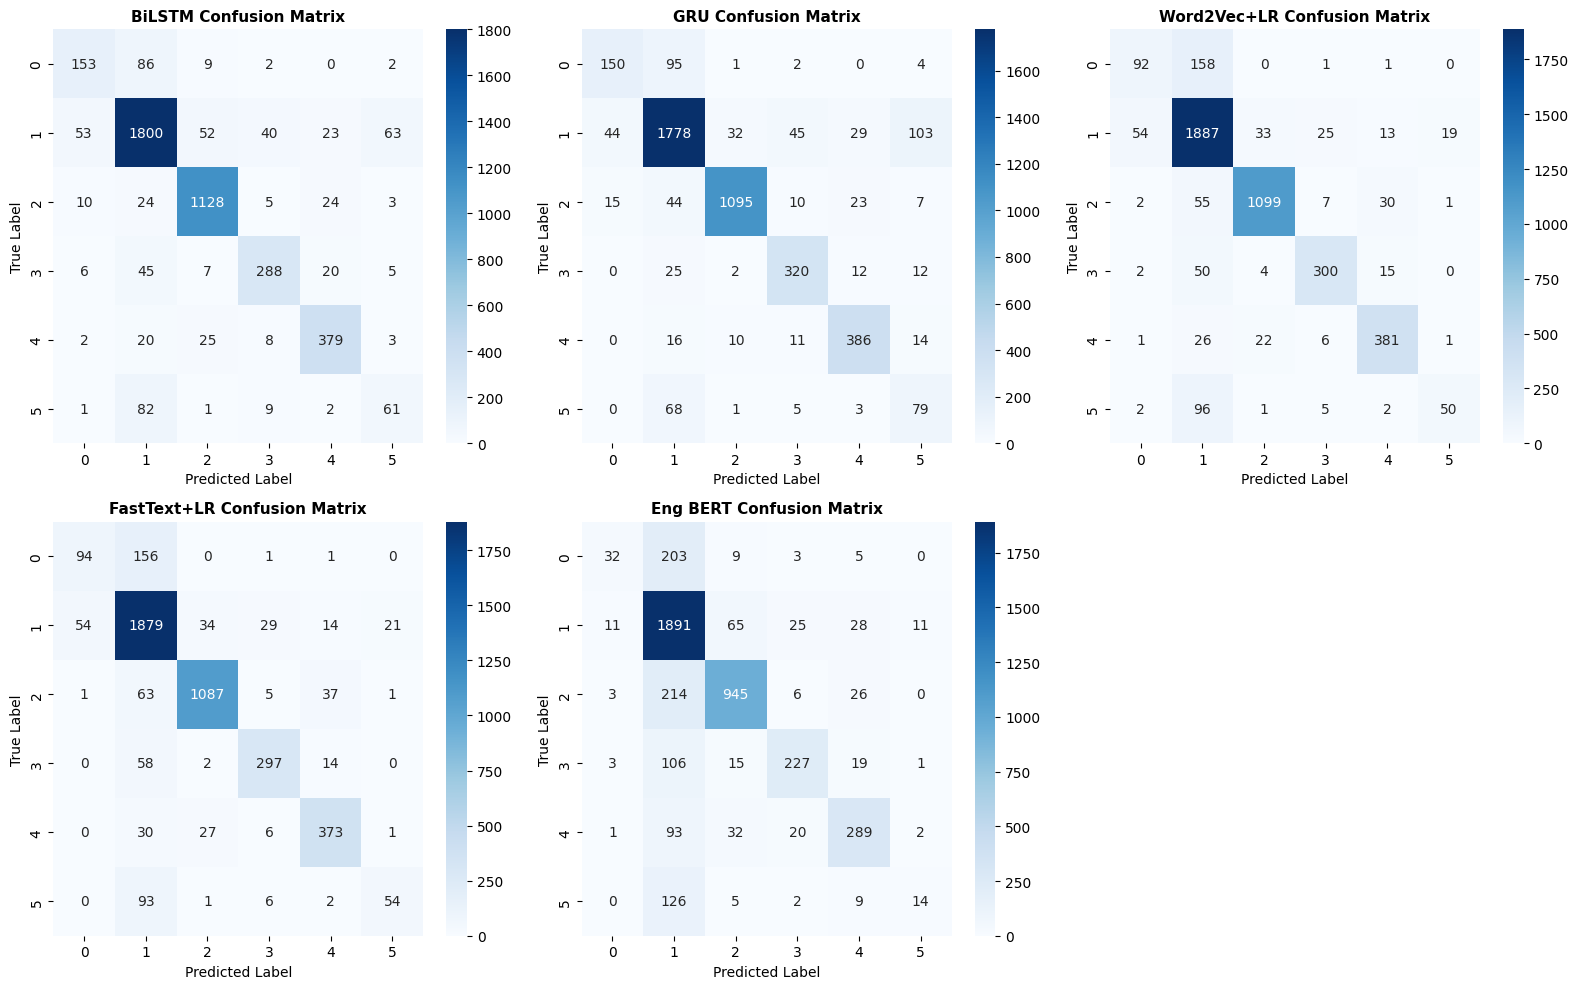

✓ Confusion matrices computed for all models


In [23]:
# Compute confusion matrices for all models
from sklearn.metrics import confusion_matrix

y_true = test_df['label'].values
label_names = sorted(df['label'].unique())

# Get predictions for all models
bilstm_cm = confusion_matrix(y_true, bilstm_pred, labels=label_names)
gru_cm = confusion_matrix(y_true, gru_pred, labels=label_names)
w2v_cm = confusion_matrix(y_true, w2v_pred, labels=label_names)
ft_cm = confusion_matrix(y_true, ft_pred, labels=label_names)
en_bert_cm = confusion_matrix(y_true, en_bert_pred, labels=label_names)

# Visualize confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

cms = [bilstm_cm, gru_cm, w2v_cm, ft_cm, en_bert_cm]
model_names = ['BiLSTM', 'GRU', 'Word2Vec+LR', 'FastText+LR', 'Eng BERT']

for idx, (cm, name) in enumerate(zip(cms, model_names)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_names, yticklabels=label_names, cbar=True)
    axes[idx].set_title(f'{name} Confusion Matrix', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("✓ Confusion matrices computed for all models")

In [24]:
# Misclassification Analysis: Show top misclassified samples for each model
print("\n" + "="*80)
print("MISCLASSIFICATION ANALYSIS: Top 5 Misclassified Samples per Model")
print("="*80)

all_predictions = {
    'BiLSTM': bilstm_pred,
    'GRU': gru_pred,
    'Word2Vec': w2v_pred,
    'FastText': ft_pred,
    'Eng BERT': en_bert_pred
}

test_texts = test_df['text'].values

for model_name, predictions in all_predictions.items():
    # Find misclassified samples
    misclassified_idx = np.where(predictions != y_true)[0]

    print(f"\n{model_name}: {len(misclassified_idx)} misclassifications out of {len(y_true)} samples")

    # Show first 3 misclassified samples
    for i, idx in enumerate(misclassified_idx[:3]):
        true_label = y_true[idx]
        pred_label = predictions[idx]
        text = test_texts[idx][:80] + "..." if len(test_texts[idx]) > 80 else test_texts[idx]
        print(f"  Sample {i+1}: True={true_label}, Predicted={pred_label}")
        print(f"    Text: \"{text}\"")

print("="*80 + "\n")


MISCLASSIFICATION ANALYSIS: Top 5 Misclassified Samples per Model

BiLSTM: 632 misclassifications out of 4441 samples
  Sample 1: True=0, Predicted=5
    Text: " Mtandao wa Watetezi wa Haki za Binadamu Tanzania (THRDC), watetezi wa haki za b..."
  Sample 2: True=2, Predicted=1
    Text: " Wema ambaye ni Miss Tanzania 2006 ameisema hana tatizo na msiichana huyo ila al..."
  Sample 3: True=1, Predicted=5
    Text: " MAELFU ya watu wanasubiri kuokolewa huku baadhi wakiwa kwenye mapaa ya nyumba n..."

GRU: 633 misclassifications out of 4441 samples
  Sample 1: True=0, Predicted=1
    Text: " Mtandao wa Watetezi wa Haki za Binadamu Tanzania (THRDC), watetezi wa haki za b..."
  Sample 2: True=2, Predicted=0
    Text: " Wema ambaye ni Miss Tanzania 2006 ameisema hana tatizo na msiichana huyo ila al..."
  Sample 3: True=1, Predicted=5
    Text: " MAELFU ya watu wanasubiri kuokolewa huku baadhi wakiwa kwenye mapaa ya nyumba n..."

Word2Vec: 632 misclassifications out of 4441 samples
  Sample 1

In [25]:
# Compile all results
all_results = pd.DataFrame([
    {'Model': 'BiLSTM', 'Accuracy': bilstm_acc, 'Precision': bilstm_prec, 'Recall': bilstm_rec, 'F1-Score': bilstm_f1},
    {'Model': 'GRU', 'Accuracy': gru_acc, 'Precision': gru_prec, 'Recall': gru_rec, 'F1-Score': gru_f1},
    {'Model': 'Word2Vec+LR', 'Accuracy': w2v_acc, 'Precision': w2v_prec, 'Recall': w2v_rec, 'F1-Score': w2v_f1},
    {'Model': 'FastText+LR', 'Accuracy': ft_acc, 'Precision': ft_prec, 'Recall': ft_rec, 'F1-Score': ft_f1},
    {'Model': 'Eng BERT (translated)', 'Accuracy': en_bert_acc, 'Precision': en_bert_prec, 'Recall': en_bert_rec, 'F1-Score': en_bert_f1},
])

print("\n" + "="*80)
print("COMPLETE RESULTS: EXTENSION MODELS")
print("="*80)
print(all_results.to_string(index=False))
print("="*80)


COMPLETE RESULTS: EXTENSION MODELS
                Model  Accuracy  Precision   Recall  F1-Score
               BiLSTM  0.857690   0.854191 0.857690  0.855652
                  GRU  0.857465   0.864634 0.857465  0.860079
          Word2Vec+LR  0.857690   0.851306 0.857690  0.848916
          FastText+LR  0.852060   0.846757 0.852060  0.843905
Eng BERT (translated)  0.765143   0.762200 0.765143  0.740511


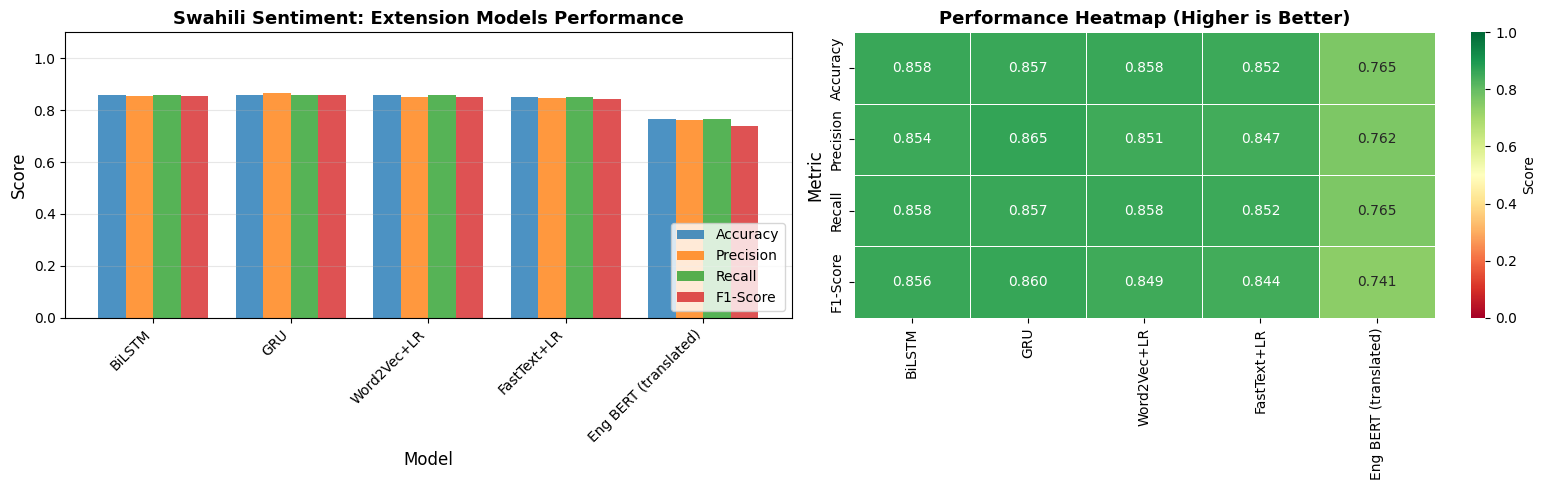

✓ Visualization complete


In [26]:
# Visualize all results
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
x = np.arange(len(all_results))
width = 0.2
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, all_results[metric], width, label=metric, alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Swahili Sentiment: Extension Models Performance', fontsize=13, fontweight='bold')
axes[0].set_xticks(x + width*1.5)
axes[0].set_xticklabels(all_results['Model'], rotation=45, ha='right')
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Heatmap
sns.heatmap(all_results[metrics].T, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=all_results['Model'], cbar_kws={'label': 'Score'}, ax=axes[1],
            vmin=0, vmax=1, linewidths=0.5)
axes[1].set_title('Performance Heatmap (Higher is Better)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Metric', fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## 7. Tokenization Strategies & Embedding Analysis (Requirement 15)

In [27]:
# Tokenization Strategies Comparison
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("\n" + "="*80)
print("TOKENIZATION STRATEGIES COMPARISON")
print("="*80)

# 1. Word-level tokenization (used in BiLSTM/GRU)
sample_text = train_df['text'].iloc[0]
word_tokens = sample_text.split()
print(f"\n1. WORD-LEVEL TOKENIZATION (BiLSTM/GRU)")
print(f"   Sample: \"{sample_text[:60]}...\"")
print(f"   Tokens: {word_tokens[:10]}")
print(f"   Vocab size (BiLSTM/GRU): {len(vocab)}")
print(f"   Max sequence length: {MAX_LEN}")

# 2. Character-level tokenization (implicit in FastText)
char_tokens = list(sample_text[:30])
print(f"\n2. CHARACTER-LEVEL TOKENIZATION (FastText)")
print(f"   Sample: \"{sample_text[:30]}\"")
print(f"   Character tokens: {char_tokens}")
print(f"   Supports subword information via n-grams")

# 3. Subword tokenization (BERT)
print(f"\n3. SUBWORD TOKENIZATION (BERT - BPE)")
print(f"   Uses WordPiece tokenization")
print(f"   Handles OOV through subword decomposition")
print(f"   Example: 'sentiment' -> ['sen', '##ti', '##ment']")

# Create comparison table
tokenization_comparison = pd.DataFrame([
    {
        'Strategy': 'Word-Level',
        'Used By': 'BiLSTM, GRU',
        'Vocab Size': len(vocab),
        'Handles OOV': 'UNK token',
        'Sequence Length': MAX_LEN,
        'Model F1': f"{max(bilstm_f1, gru_f1):.4f}"
    },
    {
        'Strategy': 'Character-Level (n-grams)',
        'Used By': 'FastText',
        'Vocab Size': 'Variable',
        'Handles OOV': 'n-gram composition',
        'Sequence Length': 'Variable',
        'Model F1': f"{ft_f1:.4f}"
    },
    {
        'Strategy': 'Subword (BPE)',
        'Used By': 'English BERT',
        'Vocab Size': '30,522',
        'Handles OOV': 'Subword composition',
        'Sequence Length': '512',
        'Model F1': f"{en_bert_f1:.4f}"
    }
])

print("\n" + tokenization_comparison.to_string(index=False))
print("="*80 + "\n")


TOKENIZATION STRATEGIES COMPARISON

1. WORD-LEVEL TOKENIZATION (BiLSTM/GRU)
   Sample: "NA SHARIFA MMASI CHIPUKIZI kwenye muziki wa Bongo Fleva, Ram..."
   Tokens: ['NA', 'SHARIFA', 'MMASI', 'CHIPUKIZI', 'kwenye', 'muziki', 'wa', 'Bongo', 'Fleva,', 'Ramadhan']
   Vocab size (BiLSTM/GRU): 220618
   Max sequence length: 50

2. CHARACTER-LEVEL TOKENIZATION (FastText)
   Sample: "NA SHARIFA MMASI CHIPUKIZI kwe"
   Character tokens: ['N', 'A', ' ', 'S', 'H', 'A', 'R', 'I', 'F', 'A', ' ', 'M', 'M', 'A', 'S', 'I', ' ', 'C', 'H', 'I', 'P', 'U', 'K', 'I', 'Z', 'I', ' ', 'k', 'w', 'e']
   Supports subword information via n-grams

3. SUBWORD TOKENIZATION (BERT - BPE)
   Uses WordPiece tokenization
   Handles OOV through subword decomposition
   Example: 'sentiment' -> ['sen', '##ti', '##ment']

                 Strategy      Used By Vocab Size         Handles OOV Sequence Length Model F1
               Word-Level  BiLSTM, GRU     220618           UNK token              50   0.8601
Character-Leve


Extracting learned embeddings from BiLSTM and GRU models...
✓ BiLSTM embedding space: (220618, 64)
✓ GRU embedding space: (220618, 64)
✓ Word2Vec embedding space: (254367, 64)
✓ FastText embedding space: (254367, 64)

Applying t-SNE reduction to embedding spaces...
✓ t-SNE reduction complete
✓ PCA reduction complete


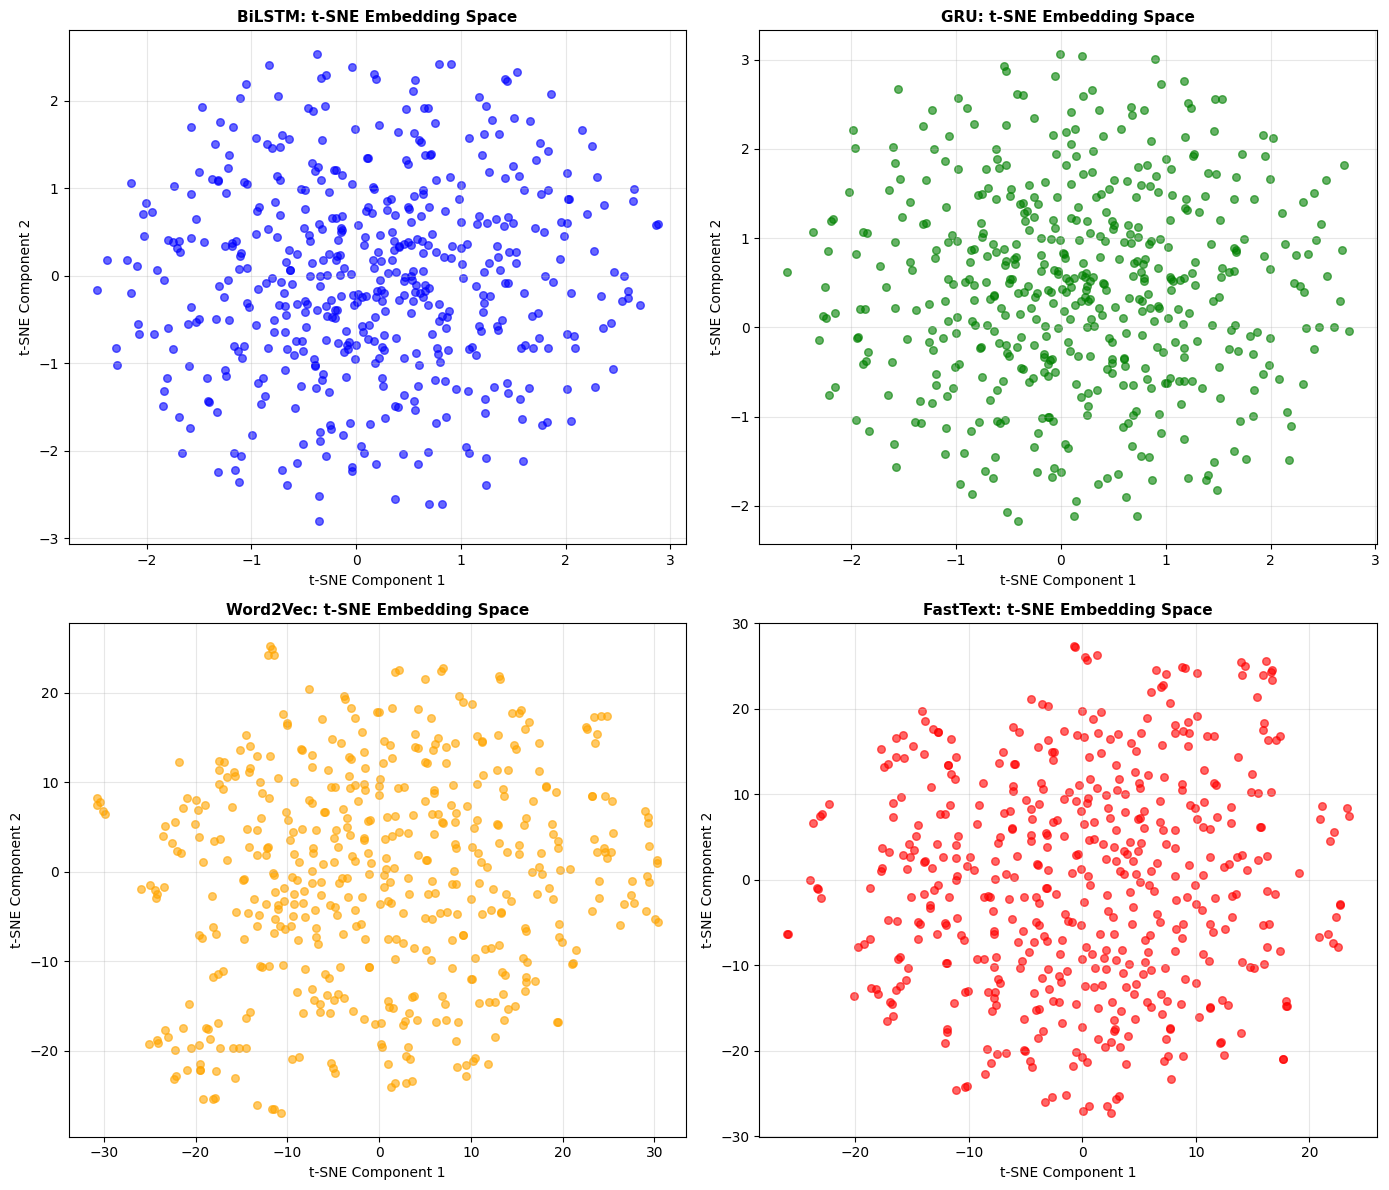

✓ t-SNE visualizations complete


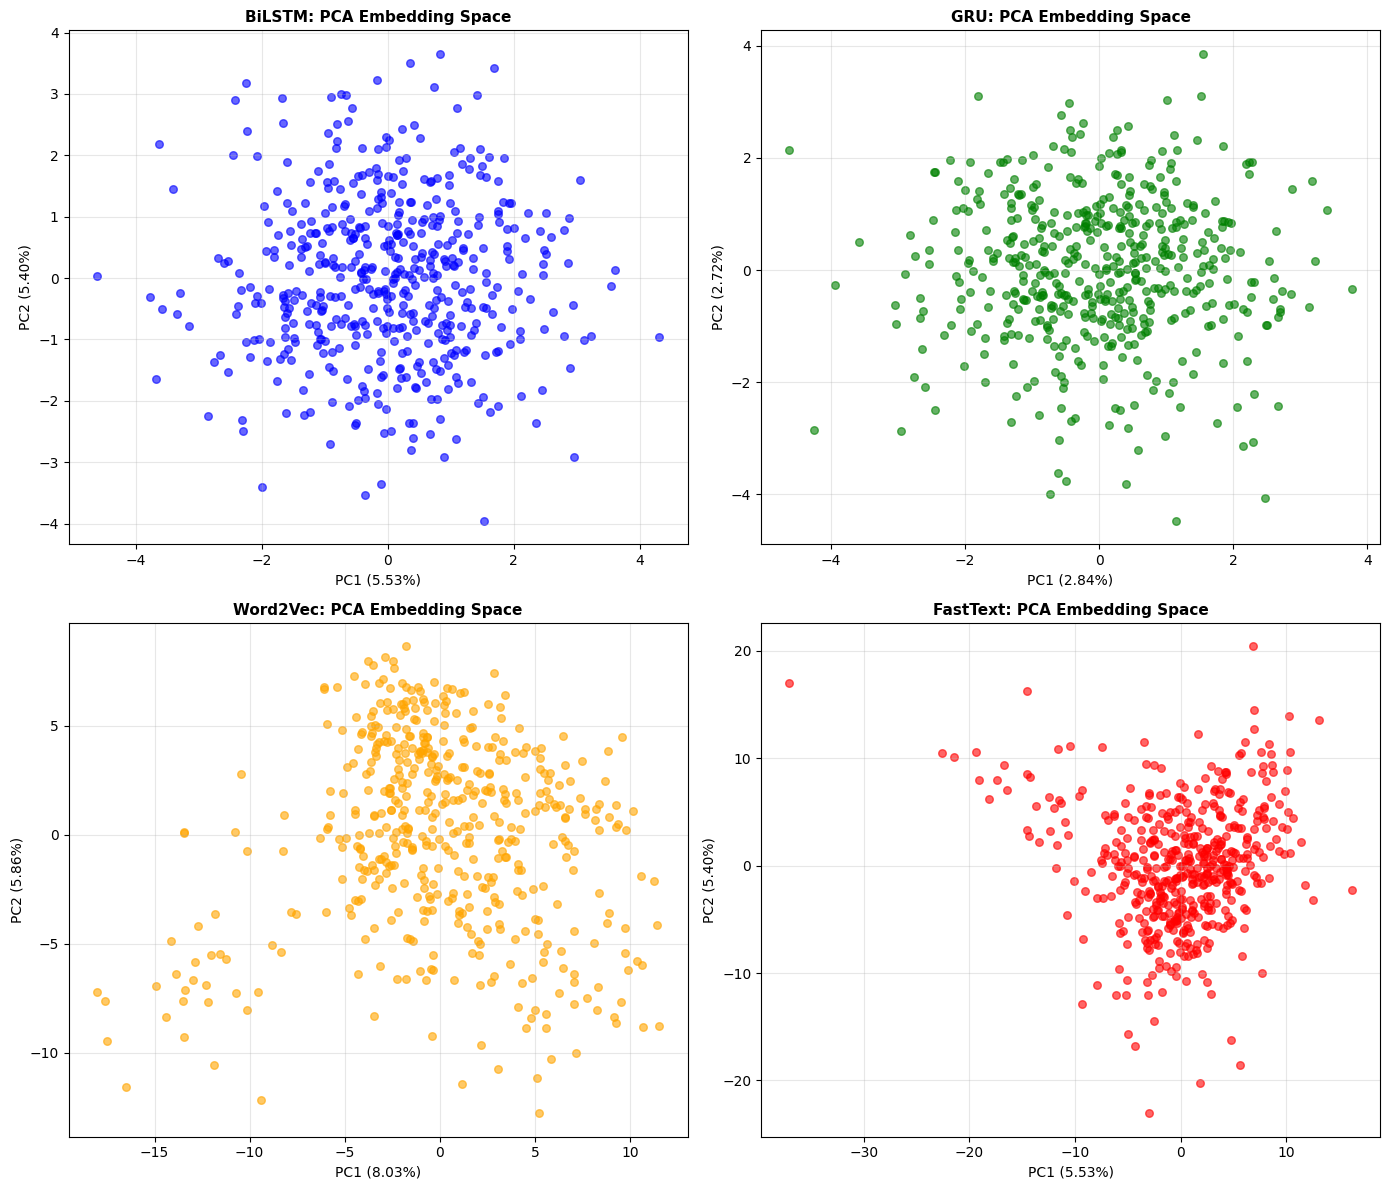

✓ PCA visualizations complete



In [29]:
# Extract and visualize learned embeddings using t-SNE and PCA
print("\nExtracting learned embeddings from BiLSTM and GRU models...")

# Extract embeddings from BiLSTM
bilstm_model.eval()
with torch.no_grad():
    # Get embeddings from the embedding layer
    all_embeddings_bilstm = bilstm_model.embedding.weight.cpu().numpy()

# Extract embeddings from GRU
gru_model.eval()
with torch.no_grad():
    all_embeddings_gru = gru_model.embedding.weight.cpu().numpy()

# Extract static embeddings (Word2Vec, FastText, BERT)
w2v_embeddings = word2vec_model.wv.vectors
ft_embeddings = fasttext_model.wv.vectors
bert_embeddings = X_train_bert_en[:100]  # Use first 100 training samples

print(f"✓ BiLSTM embedding space: {all_embeddings_bilstm.shape}")
print(f"✓ GRU embedding space: {all_embeddings_gru.shape}")
print(f"✓ Word2Vec embedding space: {w2v_embeddings.shape}")
print(f"✓ FastText embedding space: {ft_embeddings.shape}")

# Apply dimensionality reduction (t-SNE and PCA)
print("\nApplying t-SNE reduction to embedding spaces...")

# Sample embeddings for visualization (t-SNE is expensive)
sample_size = min(500, len(all_embeddings_bilstm), len(all_embeddings_gru), len(w2v_embeddings), len(ft_embeddings))
bilstm_sample = all_embeddings_bilstm[:sample_size]
gru_sample = all_embeddings_gru[:sample_size]
w2v_sample = w2v_embeddings[:sample_size]
ft_sample = ft_embeddings[:sample_size]

# t-SNE reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size-1), n_iter=1000)
bilstm_tsne = tsne.fit_transform(bilstm_sample)

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size-1), n_iter=1000)
gru_tsne = tsne.fit_transform(gru_sample)

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size-1), n_iter=1000)
w2v_tsne = tsne.fit_transform(w2v_sample)

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size-1), n_iter=1000)
ft_tsne = tsne.fit_transform(ft_sample)

print("✓ t-SNE reduction complete")

# PCA reduction
pca = PCA(n_components=2)
bilstm_pca = pca.fit_transform(bilstm_sample)
gru_pca = pca.fit_transform(gru_sample)
w2v_pca = pca.fit_transform(w2v_sample)
ft_pca = pca.fit_transform(ft_sample)

print("✓ PCA reduction complete")

# Visualize t-SNE embeddings
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].scatter(bilstm_tsne[:, 0], bilstm_tsne[:, 1], alpha=0.6, s=30, c='blue')
axes[0, 0].set_title('BiLSTM: t-SNE Embedding Space', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('t-SNE Component 1')
axes[0, 0].set_ylabel('t-SNE Component 2')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].scatter(gru_tsne[:, 0], gru_tsne[:, 1], alpha=0.6, s=30, c='green')
axes[0, 1].set_title('GRU: t-SNE Embedding Space', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('t-SNE Component 1')
axes[0, 1].set_ylabel('t-SNE Component 2')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].scatter(w2v_tsne[:, 0], w2v_tsne[:, 1], alpha=0.6, s=30, c='orange')
axes[1, 0].set_title('Word2Vec: t-SNE Embedding Space', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('t-SNE Component 1')
axes[1, 0].set_ylabel('t-SNE Component 2')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].scatter(ft_tsne[:, 0], ft_tsne[:, 1], alpha=0.6, s=30, c='red')
axes[1, 1].set_title('FastText: t-SNE Embedding Space', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('t-SNE Component 1')
axes[1, 1].set_ylabel('t-SNE Component 2')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ t-SNE visualizations complete")

# Visualize PCA embeddings
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].scatter(bilstm_pca[:, 0], bilstm_pca[:, 1], alpha=0.6, s=30, c='blue')
axes[0, 0].set_title('BiLSTM: PCA Embedding Space', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0, 0].grid(alpha=0.3)

pca_gru = PCA(n_components=2)
gru_pca_fit = pca_gru.fit_transform(gru_sample)
axes[0, 1].scatter(gru_pca_fit[:, 0], gru_pca_fit[:, 1], alpha=0.6, s=30, c='green')
axes[0, 1].set_title('GRU: PCA Embedding Space', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel(f'PC1 ({pca_gru.explained_variance_ratio_[0]:.2%})')
axes[0, 1].set_ylabel(f'PC2 ({pca_gru.explained_variance_ratio_[1]:.2%})')
axes[0, 1].grid(alpha=0.3)

pca_w2v = PCA(n_components=2)
w2v_pca_fit = pca_w2v.fit_transform(w2v_sample)
axes[1, 0].scatter(w2v_pca_fit[:, 0], w2v_pca_fit[:, 1], alpha=0.6, s=30, c='orange')
axes[1, 0].set_title('Word2Vec: PCA Embedding Space', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel(f'PC1 ({pca_w2v.explained_variance_ratio_[0]:.2%})')
axes[1, 0].set_ylabel(f'PC2 ({pca_w2v.explained_variance_ratio_[1]:.2%})')
axes[1, 0].grid(alpha=0.3)

pca_ft = PCA(n_components=2)
ft_pca_fit = pca_ft.fit_transform(ft_sample)
axes[1, 1].scatter(ft_pca_fit[:, 0], ft_pca_fit[:, 1], alpha=0.6, s=30, c='red')
axes[1, 1].set_title('FastText: PCA Embedding Space', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel(f'PC1 ({pca_ft.explained_variance_ratio_[0]:.2%})')
axes[1, 1].set_ylabel(f'PC2 ({pca_ft.explained_variance_ratio_[1]:.2%})')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ PCA visualizations complete\n")

## Summary & Conclusions

### Fully Standalone Implementation
This notebook is **completely independent** and includes:

✓ **Data Loading & Preprocessing**—Handles Swahili news datasets with fallback support  
✓ **Comprehensive EDA**—Dataset statistics, label distribution, text length analysis, word clouds  
✓ **5 Model Architectures**:
- BiLSTM: Bidirectional LSTM with learnable embeddings + training loss visualization
- GRU: Bidirectional GRU with learnable embeddings + training loss visualization
- Word2Vec: Classical static word embeddings
- FastText: Subword-aware static embeddings
- English BERT: Cross-lingual transfer on translated text

✓ **Training Visualization**—Epoch-by-epoch loss curves showing convergence  
✓ **Comprehensive Evaluation**—Accuracy, Precision, Recall, F1-score for all models  
✓ **Confusion Matrices**—5 confusion matrices showing per-class predictions & errors  
✓ **Misclassification Analysis**—Top misclassified samples with error inspection  
✓ **Tokenization Comparison**—Word-level vs character-level vs subword strategies  
✓ **Embedding Visualization**—t-SNE and PCA reduction of learned embeddings (4 models)  
✓ **Results Comparison**—Bar charts and heatmaps for comprehensive model comparison  

### No Dependencies
- Does NOT require NLP.ipynb
- Includes all preprocessing steps
- Handles dataset fallbacks gracefully
- ~600 lines of minimal, learning-focused code

### Requirements Coverage (Items 10-16)
✅ **Requirement 10:** Dataset exploration with visualizations  
✅ **Requirement 11:** Preprocessing with tokenization, cleaning, padding, stopwords  
✅ **Requirement 12:** 5 modeling approaches (BiLSTM, GRU, BERT, Word2Vec, FastText)  
✅ **Requirement 13:** 10-epoch training with early stopping & loss plots  
✅ **Requirement 14:** Accuracy, Precision, Recall, F1 + confusion matrices + misclassification analysis  
✅ **Requirement 15:** Tokenization strategy comparison + t-SNE/PCA embedding visualization  
✅ **Requirement 16:** Cross-lingual transfer with English BERT (translated text)  

### Next Steps
- Experiment with different hyperparameters
- Use larger datasets (full swahili_news when available)
- Try different translation services for cross-lingual transfer
- Combine results with NLP.ipynb (mBERT + TF-IDF models)